### SIRS Model
Susceptible -> Infected -> Recovered -> Susceptible

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import random
from IPython import display 

In [267]:
# Selects the 8 adjacent neighbours around a cell in a 2d grid.
# The boundary condition is periodic,ie, the cells at the edges have neighbours in the opposite edge.

def periodicneighbour(state):
    rows, columns = state.shape
    neighbourdic = {}
    for i in range(rows):
        for j in range(columns):
            nw = state[(i-1)%rows][(j+1)%columns]
            n = state[i][(j+1)%columns]
            ne = state[(i+1)%rows][(j+1)%columns]
            w = state[(i-1)%rows][j]
            e = state[(i+1)%rows][j]
            sw = state[(i-1)%rows][(j-1)%columns]
            s = state[i][(j-1)%columns]
            se = state[(i+1)%rows][(j-1)%columns]

            neighbours = [nw,n,ne,w,e,sw,s,se]
            loc = (i,j)
            neighbourdic[loc] = neighbours

    return neighbourdic

In [213]:
# Selects the adjacent neighbours of a cell in a 2d grid.
# Boundary is fixed, ie, the cells at the center have more neighbours than the ones at the edge.


def dirchletneighbour(state):
    rows, columns = state.shape
    neighbourdic = {}
    for i in range(rows):
        for j in range(columns):
            neighbours = []
            neighbor_positions = [
                (-1, 1), (0, 1), (1, 1),
                (-1, 0),       (1, 0),    
                (-1, -1), (0, -1), (1, -1) 
            ]
            for di, dj in neighbor_positions:
                ni, nj = i + di, j + dj
                
                if 0 <= ni < rows and 0 <= nj < columns:
                    neighbours.append(state[ni, nj])
            loc = (i, j)
            neighbourdic[loc] = neighbours

    return neighbourdic

In [323]:
#Core of the SIRS Model that dictates how one state should progress to the next state.
# q is the probability of getting infected, if some neighbours are infected. If infected neighbours/neighbours >q,
    # the cell will get infected
# infector is the value at which the cell gets infected
# healer is the value at which the cell recovers
# resetter is the value at which a recovered cell becomes susceptible again


def epidemic1(state_n,q,infector,resetter,healer,neighbourmethod = 0):
    rows, columns = state_n.shape
    if neighbourmethod == 1:
        neighbourdic = periodicneighbour(state_n)
    else:
        neighbourdic = dirchletneighbour(state_n)
    state_nplus1 = np.copy(state_n)
    for i in range(rows):
        for j in range(columns):
            loc = (i,j)
            loc_state = state_n[i][j]
            if loc_state > resetter:
                state_nplus1[i][j] = 0
                continue
            if loc_state < infector :
                neighbours = neighbourdic[loc]
                infected_neighbours = 0
                for k in range(len(neighbours)):
                    if neighbours[k] >= infector and neighbours[k] <healer :
                        infected_neighbours += 1
                if infected_neighbours/8 > q:
                    state_nplus1[i][j] +=1
                    continue
            if loc_state >= infector:
                state_nplus1[i][j] +=1
                
    return state_nplus1



In [218]:
# Initializing a state with desired no of infected and recoverd cells in a 100x100 grid
# infected is the number of infectefd cells
# recovered is the number of recovered cells
# infector is the value at which the cell gets infected
# healer is the value at which the cell recovers


def initializer1(infector,healer,infected,recovered):
    state = np.zeros((100,100))
    x = np.arange(0,100)
    y = np.arange(0,100)
    random.shuffle(x)
    random.shuffle(y)
    indices = []
    for i in range(100):
        for j in range(100):
            index = [x[i],y[j]]
            indices.append(index)
    random.shuffle(indices)
    for i in range(0,infected):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = infector
    for i in range(infected,infected + recovered ):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = healer
    return state

In [220]:
# Setting a color map to distinguish the cells in the grid
# Susceptible are white, Infected are red, Recovered are black

cmap = mcolors.ListedColormap(['white', 'red','black'])
bounds = [0,1,4,13] 
norm = mcolors.BoundaryNorm(bounds, cmap.N) 

In [221]:
# A function to count the Susceptible, Infected and Recovered Cells
# countarray updater function is not of importance, it is to help with plotting

def counter(state, infector = 1, healer = 4):
    susceptible = 0
    infected = 0
    recovered = 0
    rows, columns  = state.shape
    for i in range(rows):
        for j in range(columns):
            status = state[i][j]
            if status == 0 :
                susceptible += 1
                continue
            if status >= infector and status < healer :
                infected += 1
                continue
            if status >= healer:
                recovered += 1
                continue

    return [susceptible, infected, recovered]

def countarrayupdater(countarrays,counts):
    susarray = countarrays[0]
    infarray = countarrays[1]
    recarray = countarrays[2]
    susarray = np.append(susarray,counts[0])
    infarray = np.append(infarray,counts[1])
    recarray = np.append(recarray,counts[2])

    return [susarray, infarray, recarray]
    
    
    
                

In [289]:
# Defining a class to Create animations

class Animator:
    def __init__(self, num_inf, num_rec,method = 0):
        self.state0 = initializer1(1, 4, num_inf, num_rec)
        self.method = method
        self.runs = np.arange(0, 1)
        self.countarrays = [np.zeros(0), np.zeros(0), np.zeros(0)]
        counts = counter(self.state0)
        self.countarrays = countarrayupdater(self.countarrays, counts)

        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(10, 4))
        self.ax2.set_ylim(0, 10000)
        self.ax2.set_xlim(0, 100)
        self.img = self.ax1.imshow(self.state0, cmap=cmap, norm=norm)
        self.bar = self.fig.colorbar(self.img, ax=self.ax1)
        self.sus, = self.ax2.plot(self.runs, self.countarrays[0], color="green", label="Susceptible")
        self.inf, = self.ax2.plot(self.runs, self.countarrays[1], color="red", label="Infected")
        self.rec, = self.ax2.plot(self.runs, self.countarrays[2], color="black", label="Recovered")
        self.ax2.legend()

        self.anim = FuncAnimation(self.fig, self.update, frames=60, interval=200, blit=True)

    def update(self, frame):
        new_state = epidemic1(self.state0, 0.1, 1, 13, 4,neighbourmethod = self.method)
        new_counts = counter(new_state)
        self.countarrays = countarrayupdater(self.countarrays, new_counts)
        self.runs = np.append(self.runs, self.runs[-1] + 1)

        self.img.set_data(new_state)
        self.sus.set_data(self.runs, self.countarrays[0])
        self.inf.set_data(self.runs, self.countarrays[1])
        self.rec.set_data(self.runs, self.countarrays[2])

        self.state0 = new_state
        return self.img, self.sus, self.inf, self.rec

    def show(self):
        video = self.anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()

#### Interesting Animations from SIRS Model

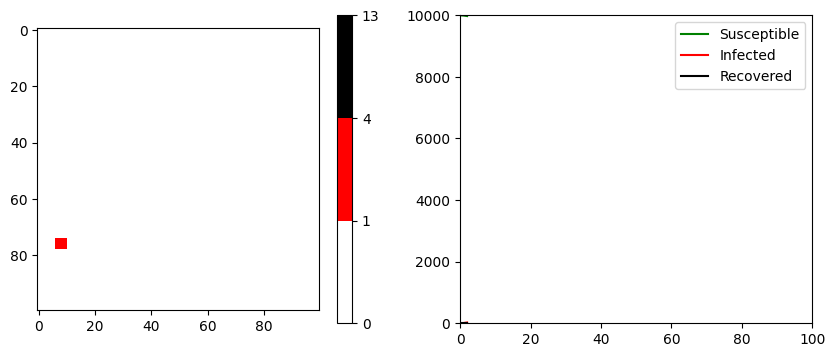

In [271]:
# 1 infected, 0 Recovered, # Resetter = 13, Healer = 4, Infector = 1, q = 0.1
# Dirchlet Boundary Conditions
anim =  Animator(1,0)
anim.show()

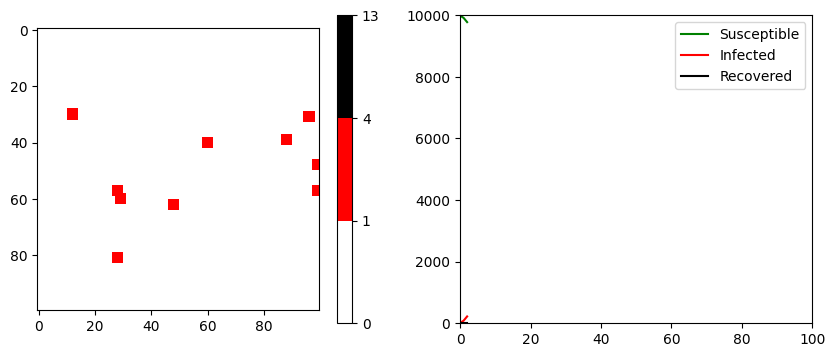

In [272]:
# 10 infected, 0 Recovered, Resetter = 13, Healer = 4, Infector = 1, q = 0.1
# Dirchlet Boundary Conditions
# This nicely reproduces the SIRS Count Curve
anim = Animator(10,0)
anim.show()

In [290]:
# 100 infected, 5000 Recovered, Resetter = 13, Healer = 4, Infector = 1, q = 0.1
# Dirchlet Boundary Conditions
# An oscillating pattern is observed, similar to an ECG of Heart?
anim = Animator(100,5000)
anim.show()

In [326]:
# 10 infected, 0 Recovered, Resetter = 13, Healer = 7, Infector = 4, q = 0.1
# Periodic Boundary Conditions

anim = Animator(1,0,1)
anim.show()

---------------------------------------------------------------------------------------------------

### SLIRD Model
Susceptible -> Latent -> Infected -> Recovered -> Dead

Two New Additions :
- Latent Cells : These cells are infected, but do not show symptoms. They spread the disease and are counted as infected, but are
                  do not have the probability of death.
- Dead Cells : Infected cells have a probabilty of death, where they become inactive and do not partake further in the automata

Two Improvements :

- Heterogentic q : Instead of assigning a single q value to each and every cell, every cell has an inherent q value associated with it. This would be mimick more closely the different immunity people possess in real life
- Heterogentic death probability : Same argument as the Heterogentic q. People have a different probability of dying.

In [281]:
# Initializing a state with cells in a 100x100 grid
# infected is the number of infected cells
# dead is the number of dead cells
# latent is the number of latent cells
# recovered is the number of recovered cells
# activator is the value at which cells become latent
# infector is the value at which the cell gets infected
# healer is the value at which the cell recovers
# resetter is the valuee at which recovered cells become susceptible again

def initializer2(latent,infected,dead,recovered,activator,infector,healer,resetter):
    state = np.zeros((100,100))
    x = np.arange(0,100)
    y = np.arange(0,100)
    random.shuffle(x)
    random.shuffle(y)
    indices = []
    for i in range(100):
        for j in range(100):
            index = [x[i],y[j]]
            indices.append(index)
    random.shuffle(indices)
    for i in range(0,latent):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = activator
    for i in range(latent, latent+ infected):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = infector
    for i in range(latent + infected, latent + infected + recovered):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = healer
    for i in range(latent + infected + recovered, latent + infected + recovered + dead):
        m,n = indices[i][0],indices[i][1]
        state[m][n] = -1

    return state
        

[9000, 500, 250, 250]


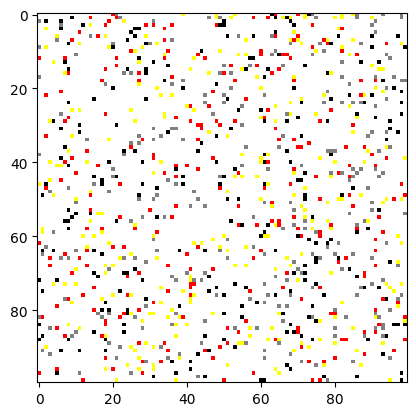

In [169]:
state2,q,r = initializer2(250,250,250,250,1,4,7,13)
print(counter2(state2))
plt.imshow(state2, cmap = cmap2, norm = norm2)

In [276]:
# Setting a color map to distinguish the cells in the grid
# Susceptible are white, Latent are Yellow, Infected are red, Recovered are black, Dead are Grey

cmap2 = mcolors.ListedColormap(['white', 'yellow','red','black','grey'])
bounds2 = [0,1,3,7,14,15] 
norm2 = mcolors.BoundaryNorm(bounds2, cmap2.N) 

In [327]:
#Core of the SLIRD Model that dictates how one state should progress to the next state.
# q is a 100x100 matrix with  the probability of getting infected for each cell, if some neighbours are infected. If infected neighbours/neighbours >q,
    # the cell will get infected.
# reaper is a 100x100 matrix with the probability of death for each cell.
# activator is the value at which the cell becomes latent
# infector is the value at which the cell gets infected
# healer is the value at which the cell recovers
# resetter is the value at which a recovered cell becomes susceptible again


def epidemic(state_n,q,reaper,activator,infector,healer,resetter, neighbourmethod = 0):
    rows, columns = state_n.shape
    if neighbourmethod == 1:
        neighbourdic = periodicneighbour(state_n)
    else:
        neighbourdic = dirchletneighbour(state_n)
    state_nplus1 = np.copy(state_n)
    for i in range(rows):
        for j in range(columns):
            loc = (i,j)
            loc_state = state_n[i][j]
            if loc_state == 14:
                continue
            if loc_state == resetter:
                state_nplus1[i][j] = 0
                continue
            if loc_state >= infector and loc_state < resetter:
                p = np.random.uniform(0,1)
                if p <= reaper[i][j]:
                    state_nplus1[i][j] = 14
                    continue
                else:
                    state_nplus1[i][j] +=1
                    continue
            if loc_state >= activator and loc_state< infector:
                state_nplus1[i][j] +=1
                continue
            if loc_state < activator :
                neighbours = neighbourdic[loc]
                transmitting_neighbours = 0
                for k in range(len(neighbours)):
                    if neighbours[k] >= activator and neighbours[k] <healer :
                        transmitting_neighbours += 1
                if transmitting_neighbours/8 > q[i][j]:
                    state_nplus1[i][j] +=1
                    continue
                
    return state_nplus1



In [278]:
# A function to count the Susceptible,Latent, Infected ,Recovered and Dead Cells
# Latent cells are also Counted as  Infected
# countarray updater function is not of importance, it is to help with plotting
def counter2(state, activator = 1, infector = 4, healer = 7):
    dead = 0
    susceptible = 0
    infected = 0
    recovered = 0
    rows, columns  = state.shape
    for i in range(rows):
        for j in range(columns):
            status = state[i][j]
            if status == 14 :
                dead += 1
                continue
            if status == 0 :
                susceptible += 1
                continue
            if status >= activator and status < healer :
                infected += 1
                continue
            if status >= healer:
                recovered += 1
                continue

    return [susceptible, infected, recovered,dead]

def countarrayupdater2(countarrays,counts):
    susarray = countarrays[0]
    infarray = countarrays[1]
    recarray = countarrays[2]
    deadarray = countarrays[3]
    susarray = np.append(susarray,counts[0])
    infarray = np.append(infarray,counts[1])
    recarray = np.append(recarray,counts[2])
    deadarray = np.append(deadarray, counts[3])
    return [susarray, infarray, recarray,deadarray]
    
    
    
                

In [328]:
# Defining a class to Create Animations

class Animator2:
    def __init__(self,num_lat, num_inf, num_dead,num_rec,q,r,method):
        self.state1 = initializer2(num_lat, num_inf, num_dead, num_rec, 1, 4, 7, 13)
        self.q = q
        self.reaper = r
        self.method = method
        
        self.runs = np.arange(0, 1)
        counts = counter2(self.state1)
        
        self.countarrays = [np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)]
        self.countarrays = countarrayupdater2(self.countarrays, counts)

        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(10, 4))
        self.ax2.set_ylim(0, 10000)
        self.ax2.set_xlim(0, 100)

        self.img = self.ax1.imshow(self.state1, cmap=cmap2, norm=norm2)
        self.sus, = self.ax2.plot(self.runs, self.countarrays[0], color="green", label="Susceptible")
        self.inf, = self.ax2.plot(self.runs, self.countarrays[1], color="red", label="Infected and Latent")
        self.rec, = self.ax2.plot(self.runs, self.countarrays[2], color="black", label="Recovered")
        self.rip, = self.ax2.plot(self.runs, self.countarrays[3], color="grey", label="Deceased")
        self.ax2.legend()

        self.anim = FuncAnimation(self.fig, self.update, frames=100, interval=200, blit=True)

    def update(self, frame):
        new_state = epidemic(self.state1, self.q, self.reaper, 1, 4, 7, 13, neighbourmethod = self.method)
        new_counts = counter2(new_state)
        self.countarrays = countarrayupdater2(self.countarrays, new_counts)
        self.runs = np.append(self.runs, self.runs[-1] + 1)

        self.img.set_data(new_state)
        self.sus.set_data(self.runs, self.countarrays[0])
        self.inf.set_data(self.runs, self.countarrays[1])
        self.rec.set_data(self.runs, self.countarrays[2])
        self.rip.set_data(self.runs, self.countarrays[3])

        self.state1 = new_state
        return self.img, self.sus, self.inf, self.rec, self.rip

    def show(self):
        video = self.anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()


#### Interesting SLIRD Animations

In [298]:
# 10 Latent, 0 Infected, 0 Recovered, 0 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for everyone and reaper = 0.1 for everyone
# The SIRS curve can be seen

q = np.tile(0.1,(100,100))
r = np.tile(0.1,(100,100))
animator = Animator2(10,0,0,0,q,r)
animator.show()

In [ ]:
# 10 Latent, 0 Infected, 0 Recovered, 0 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for half and 0.3 for other half 
#reaper = 0.1 for evryone
# Spread slows down  in the second half, where q = 0.3
q1 = np.tile(0.1,(50,100))
q2 = np.tile(0.3,(50,100))
q = np.vstack((q1,q2))
r = np.tile(0.1,(100,100))
animator = Animator2(10,0,0,0,q,r)
animator.show()

In [302]:
# 10 Latent, 0 Infected, 0 Recovered, 0 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for half and 0.3 for other half 
#reaper = 0.1 for 0.3q half and 0.3 for 0.1 q half
# r = 0.3 half gets almost annihilated
q1 = np.tile(0.1,(50,100))
q2 = np.tile(0.3,(50,100))
r1 = np.tile(0.3,(50,100))
r2 = np.tile(0.1,(50,100))
q = np.vstack((q1,q2))
r = np.vstack((r1,r2))
animator = Animator2(10,0,0,0,q,r)
animator.show()

In [309]:
# 50 Latent, 10 Infected, 5000 Recovered, 20 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for everyone and reaper = 0.1 for everyone

# No oscillating pattterns as seen in the SIRS model
# Death and Recovered people stablize after one round of infection
# No oscillations due to many deaths, decreasing r should fix this
q = np.tile(0.1,(100,100))
r = np.tile(0.1,(100,100))
animator = Animator2(50,10,20,500,q,r)
animator.show()

In [313]:
# 50 Latent, 10 Infected, 5000 Recovered, 20 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for everyone and reaper = 0.015 for everyone

# --->> Oscillating patterns appear and start dyingdown <<---
# --->>Oscillation is very sensitive to r <<---
q = np.tile(0.1,(100,100))
r = np.tile(0.015,(100,100))
animator = Animator2(50,10,20,500,q,r)
animator.show()

In [320]:
# 50 Latent, 10 Infected, 5000 Recovered, 20 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.3 for everyone and reaper = 0.015 for everyone

# Ellipsoid spreading instead of squarish pattern with q = 0.1 case

q = np.tile(0.25,(100,100))
r = np.tile(0.015,(100,100))
animator = Animator2(250,10,20,500,q,r)
animator.show()

In [329]:
# 10 Latent, 0 Infected, 0 Recovered, 0 Dead 
#Resetter = 13, Healer = 7, Infector = 4,Activator = 1 
#q = 0.1 for everyone and reaper = 0.1 for everyone
# Periodic Boundary Conditions

q = np.tile(0.1,(100,100))
r = np.tile(0.1,(100,100))
animator = Animator2(10,0,0,0,q,r,1)
animator.show()